### I need surface roughness length (in m) to calculate wind at 2m elevation  
References: 


Surface Hydrology by Ven Te Chow page 45 & 46: https://wecivilengineers.files.wordpress.com/2017/10/applied-hydrology-ven-te-chow.pdf  
NoahMP MP Table: https://ral.ucar.edu/sites/default/files/public/product-tool/noah-multiparameterization-land-surface-model-noah-mp-lsm/MPTABLE.TBL_.txt

Surface roughness length calculation in NoahMP  

Based on https://github.com/NCAR/noahmp/blob/master/src/module_sf_noahmplsm.F  

Starting from line 2059 
``` 
! vegetated or non-vegetated
    VAI = ELAI + ESAI
    VEG = .FALSE.
    IF(VAI > 0.0) VEG = .TRUE.
```
Starting from line 2075
```
! ground roughness length
     IF(IST == 2) THEN
       IF(TG .LE. TFRZ) THEN
         Z0MG = 0.01 * (1.0-FSNO) + FSNO * parameters%Z0SNO
       ELSE
         Z0MG = 0.01  
       END IF
     ELSE
       Z0MG = Z0 * (1.0-FSNO) + FSNO * parameters%Z0SNO
     END IF
! roughness length and displacement height
     ZPDG  = SNOWH
     IF(VEG) THEN
        Z0M  = parameters%Z0MVT
        ZPD  = 0.65 * parameters%HVT
        IF(SNOWH.GT.ZPD) ZPD  = SNOWH
     ELSE
        Z0M  = Z0MG
        ZPD  = ZPDG
     END IF
```

Based on monthly values of LAI and SAI in MP-TABLE, the LAI and SAI are set zero for all months for the following MODIS LU classes:  
13 (Urban), 15 (Snow and Ice), 16 (Barren or Sparsely Vegetated), 17 (Water), & 20 (Barren Tundra).  
For LU classes 15, 16, 17, and 20, Z0M is set to 0.01

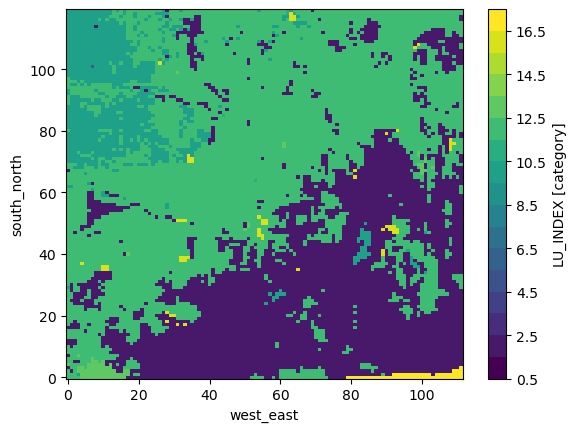

In [13]:
import xarray as xr
import numpy as np

geo_dir = '/g/data/w97/ad9701/WRF-Hydro/SEA/WPS_domain4_4km_newLU_newSoil/'
ds_geo = xr.open_dataset(geo_dir + 'geo_em.d01.nc')

levels = np.linspace(0.5, 17.5, 18)
ds_geo['LU_INDEX'][0,:,:].plot(levels = levels)

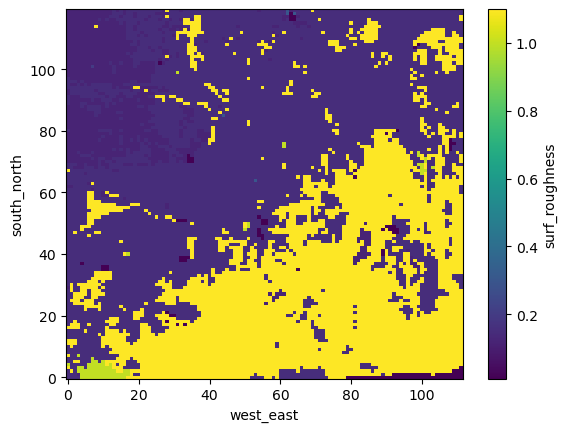

In [17]:
ds_sr = xr.open_dataset('/g/data/w97/ad9701/WRF-Hydro/ERA5Land_regrid/regional/surface_roughness.nc')
ds_sr['surf_roughness'].plot()

In [24]:
ds_wind = xr.open_dataset('/g/data/w97/ad9701/WRF-Hydro/ERA5Land_regrid/regional/wind_10m_and_2m.nc')
ds_wind

<xarray.Dataset>
Dimensions:  (Time: 1, south_north: 120, west_east: 112)
Dimensions without coordinates: Time, south_north, west_east
Data variables:
    U2m      (Time, south_north, west_east) float64 ...
    U10m     (Time, south_north, west_east) float64 ...

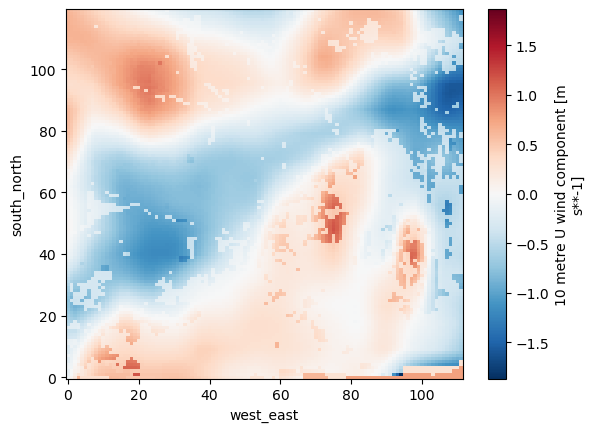

In [25]:
ds_wind['U2m'].plot()

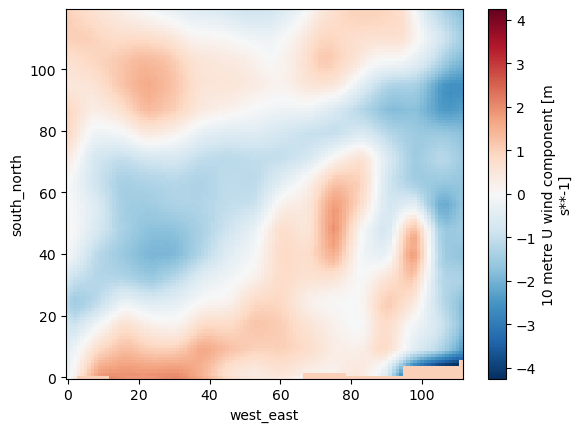

In [26]:
ds_wind['U10m'].plot()

In [48]:
((8760-1)*2)+(8760*2)+8784

43822

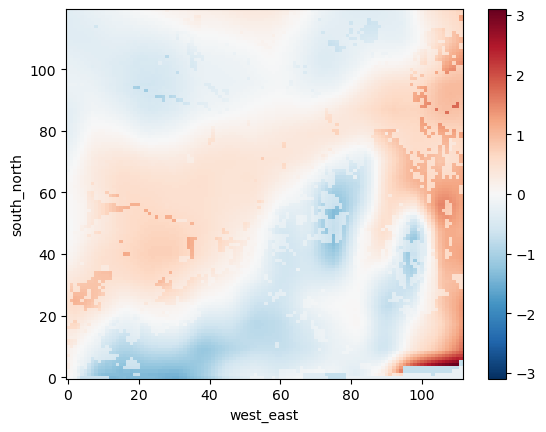

In [46]:
(ds_wind['U2m'] - ds_wind['U10m']).plot()

In [38]:
import math

numerator = xr.apply_ufunc(math.log, 2/ds_sr['surf_roughness'], vectorize=True)
denominator = xr.apply_ufunc(math.log, 10/ds_sr['surf_roughness'], vectorize=True)

In [39]:
u2m = ds_wind['U10m']*numerator/denominator

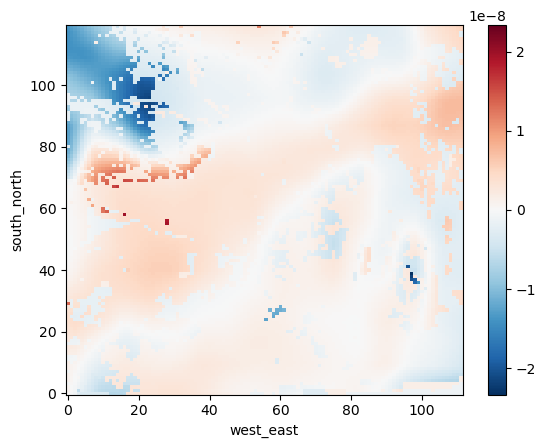

In [44]:
(ds_wind['U2m'] - u2m).plot()

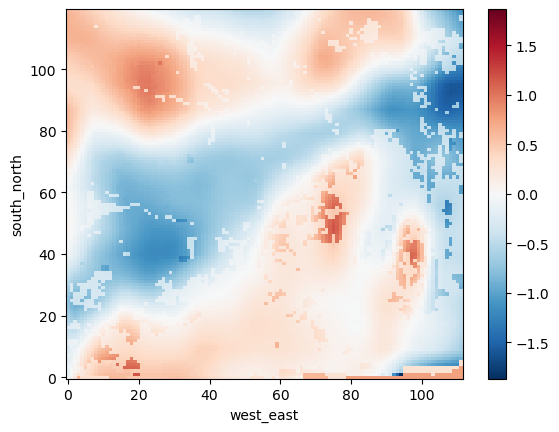

In [41]:
u2m[0,:,:].plot()

In [30]:
2/ds_sr['surf_roughness']

<xarray.DataArray 'surf_roughness' (south_north: 120, west_east: 112)>
array([[ 13.333333 ,  13.333333 ,  13.333333 , ..., 200.       ,
        200.       , 200.       ],
       [ 13.333333 ,  13.333333 ,  13.333333 , ..., 200.       ,
        200.       , 200.       ],
       [ 13.333333 ,   1.8181818,  13.333333 , ..., 200.       ,
        200.       , 200.       ],
       ...,
       [ 16.666668 ,  16.666668 ,  16.666668 , ...,  13.333333 ,
         13.333333 ,   1.8181818],
       [ 16.666668 ,  16.666668 ,  16.666668 , ...,  13.333333 ,
         13.333333 ,  13.333333 ],
       [ 16.666668 ,  16.666668 ,  16.666668 , ...,  13.333333 ,
         13.333333 ,  13.333333 ]], dtype=float32)
Dimensions without coordinates: south_north, west_east

In [19]:
for lu in range(1, 21):
    da_temp = ds_sr['surf_roughness'].where(ds_geo['LU_INDEX']==lu)
    sr_unq = np.unique(da_temp.values)
    print('LU =' + str(lu))
    print(sr_unq)
    print('------------------')

LU =1
[nan]
------------------
LU =2
[1.1 nan]
------------------
LU =3
[nan]
------------------
LU =4
[nan]
------------------
LU =5
[nan]
------------------
LU =6
[0.2 nan]
------------------
LU =7
[nan]
------------------
LU =8
[nan]
------------------
LU =9
[nan]
------------------
LU =10
[0.12  nan]
------------------
LU =11
[0.3 nan]
------------------
LU =12
[0.15  nan]
------------------
LU =13
[ 1. nan]
------------------
LU =14
[nan]
------------------
LU =15
[nan]
------------------
LU =16
[0.01  nan]
------------------
LU =17
[0.01  nan]
------------------
LU =18
[nan]
------------------
LU =19
[nan]
------------------
LU =20
[nan]
------------------


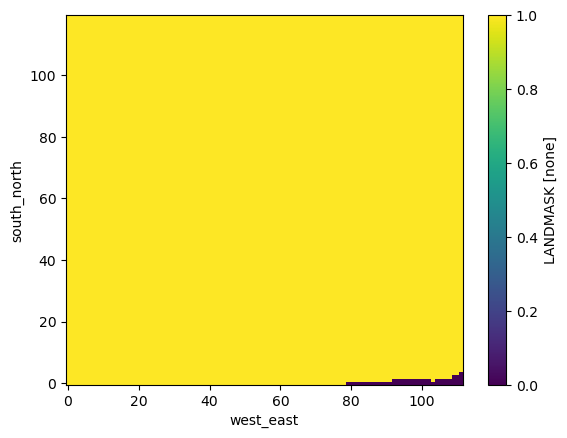

In [17]:
ds_geo['LANDMASK'][0,:,:].plot()

### Missing value problem
Find reasonable constant based on a judgement call

In [2]:
import xarray as xr
ds = xr.open_mfdataset('/g/data/w97/ad9701/WRF-Hydro/ERA5Land_regrid/regional/output_files_test/20160101*', concat_dim = 'Time', combine = 'nested')
ds

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'PSFC' has multiple fill values {-32767.0, 9.969209968386869e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'PSFC' has multiple fill values {-32767.0, 9.969209968386869e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'PSFC' has multiple fill values {-32767.0, 9.969209968386869e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'PSFC' has multiple fill values {-32767

<xarray.Dataset>
Dimensions:     (Time: 23, south_north: 120, west_east: 112)
Dimensions without coordinates: Time, south_north, west_east
Data variables:
    Times       (Time) |S20 b'2016-01-01_01:00:00' ... b'2016-01-01_23:00:00'
    valid_time  (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    lat         (Time, south_north, west_east) float32 dask.array<chunksize=(1, 120, 112), meta=np.ndarray>
    lon         (Time, south_north, west_east) float32 dask.array<chunksize=(1, 120, 112), meta=np.ndarray>
    PSFC        (Time, south_north, west_east) float64 dask.array<chunksize=(1, 120, 112), meta=np.ndarray>

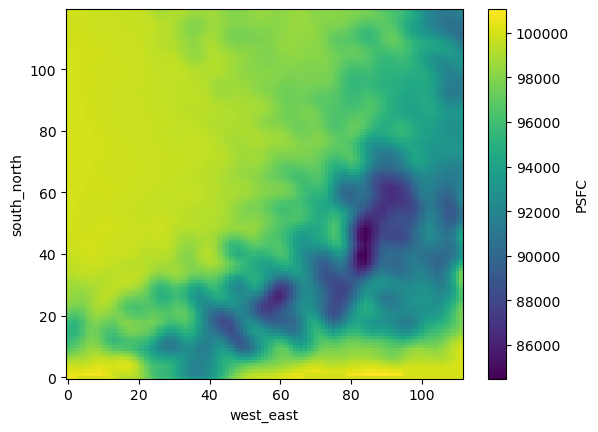

In [4]:
ds['PSFC'].mean('Time').plot()

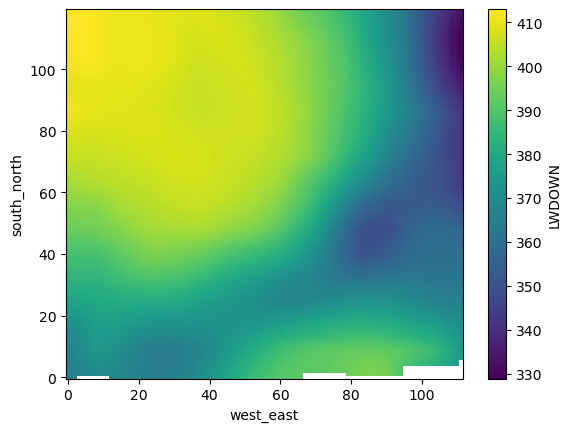

In [30]:
ds['LWDOWN'].mean('Time').plot()

In [5]:
ds_wNan = xr.open_dataset("/g/data/w97/ad9701/WRF-Hydro/ERA5Land_regrid/regional/output_files_domain4_wnan/2016010101.LDASIN_DOMAIN1")
ds_wNan

<xarray.Dataset>
Dimensions:     (Time: 1, south_north: 120, west_east: 112)
Dimensions without coordinates: Time, south_north, west_east
Data variables:
    Times       |S20 ...
    valid_time  (Time) datetime64[ns] ...
    lat         (south_north, west_east) float32 ...
    lon         (south_north, west_east) float32 ...
    PSFC        (Time, south_north, west_east) float64 ...
    T2D         (Time, south_north, west_east) float64 ...
    U2D         (Time, south_north, west_east) float64 ...
    V2D         (Time, south_north, west_east) float64 ...
    Q2D         (Time, south_north, west_east) float64 ...
    RAINRATE    (Time, south_north, west_east) float64 ...
    SWDOWN      (Time, south_north, west_east) float64 ...
    LWDOWN      (Time, south_north, west_east) float64 ...